<a href="https://colab.research.google.com/github/Camilo1992/atmos-optics/blob/Cambranch/Tarea_1_Propagador_Camilo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1, Propagador óptico
##Camilo Weinberger
 @: camilo.weinberg@gmail.com

Se importan las librerías correspondientes:


*   numpy para cálculos
*   matplotlib para herramientas de gráficos



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

Se definen los valores iniciales:
* tamaño imagen
* tamaño pixel
* tamaño pupila
* grosor lente
* longitud de onda
* distancia focal

In [2]:
size= 1000
R = size/2 #pix
Lm = 3*10**-3
px_s = Lm/size
lamb = 500*10**-9 # red
k=2*np.pi/lamb
f = 0.5    #foco en m
d_0 = 1*10**-3    # lente de 1mm de grosor.

Se programa la máscara para el propagador $\mathbb{I}_\Sigma (\boldsymbol{\rho^\prime})$ (pupil)


In [3]:
def pupil(size,px_s,R):
  X = np.linspace(-(size/2)*px_s,(size/2)*px_s,size)
  Y = X
  xx, yy = np.meshgrid(X,Y,sparse=True)
  r = np.sqrt(xx**2+yy**2)
  mask = np.ones((size,size))
  mask = mask*(r<=px_s*R)
  return mask,r

mask,r=pupil(size,px_s,R)

Definimos la función tramitancia para un lente curvo a partir de la ecuación $t(x)=\mathbb{I}_\Sigma(\boldsymbol{\rho})e^{ik\Delta_0}\exp\left[-i\frac{k}{2f}\boldsymbol{\rho}^2\right]$

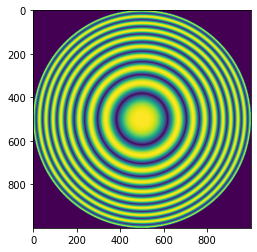

In [4]:
T_t=mask*np.exp(1j*k*(d_0-r**2/(2*f)))
plt.imshow(abs(np.real(T_t)))
plt.show()

Definimos la función correspondiente a la aproximación de Fresnell $ u(\boldsymbol{\rho}, L)=\frac{e^{i k\left(L+\frac{1}{2 L} \rho^{2}\right)}}{i \lambda L} \int_{\mathbb{R}^{2}} u\left(\boldsymbol{\rho}^{\prime}, 0\right) \exp \left(i \frac{k}{L} \boldsymbol{\rho} \cdot \boldsymbol{\rho}^{\prime}\right) d^{2} \rho^{\prime} $

"*Alternativamente, podremos escribir esta convoluci ́on como el producto de la transformada del campo inicial por la transformada de la función impulso-respuesta*" [Apunte_Fourier_Optics.pdf](https://drive.google.com/file/d/1HTJOuNdlZwOVJ-tPgbDqYZMJhhZm2Sow/view) 

> $H(\boldsymbol{\omega})=e^{i k d_{0}} \exp \left(-\frac{i L}{2 k} \omega^{2}\right)$



In [5]:
def focus(Uin,f):
  size_Uin = Uin.shape
  P = pupil(size_Uin[0],px_s,R)[0]
  T_t = P*np.exp(-1j*k*(r**2)/(2*f))
  Uout = Uin*T_t
  return Uout
  
def Prop(Uin,z):
  
  H = np.exp(-1j*np.pi*np.pi*z*r**2/lamb*10**3)
  H = np.fft.fftshift(H)
  U1 = np.fft.fft2(np.fft.fftshift(Uin))
  u2 = np.fft.ifftshift(np.fft.ifft2(U1*H))
  return u2

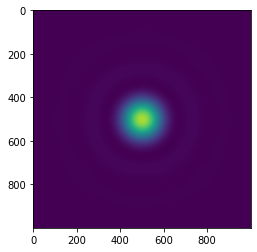

In [6]:
Pre_im=focus(pupil(1000,px_s,10)[0],f=0.05)
Image = Prop(Pre_im,z=0.05)
plt.imshow(np.abs(Image**2),)
plt.show()

Para Probar el código se cargaron librerías mediante Google Colab. La imágen utilizada es de $1000x1000$ pixeles y se crea temporalmente en la carpeta de trabajo.

In [7]:
from skimage import data
from skimage.color import rgb2gray

im1 = plt.imread('1234.jpg')
im1 = rgb2gray(im1)

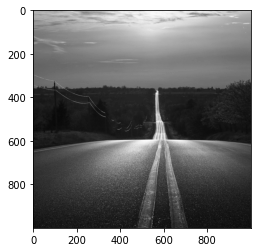

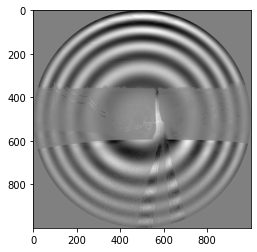

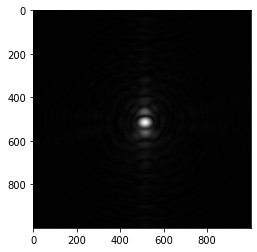

In [8]:
plt.imshow(abs(im1),'gray')
plt.show()
Image = focus(im1,f=0.5)
plt.imshow(np.real(Image),'gray')
plt.show()
Image2 = Prop(Image,z=0.5)
plt.imshow(np.abs(Image2),'gray')
plt.show()

## Observación

Este sistema funciona bien para ciertos parámetros en la simulación, esto ocurre cuando la imágen es mayor en tamaño respecto a la pupila, para caso contrario la simulación considerará el borde  de la imágen como un obstaculo y en la propagación aparecerán deformaciones asociados a dichos bordes.

---


## Solución


En el capítulo 7 del Voelz [Computational fourier optics: A MATLAB tutorial](https://drive.google.com/file/d/1URAoRYjupz7E_ei5rFyL-uzsaPJHpiK9/view) se menciona este problema y se resuelve añadindo en consepto del número f, que relaciona el diámetro de la pupila respecto a la distancia focal del lente de la forma
$ F/\text{#} =\frac{d}{f} $
* Esto se corrige mediante la OTF (optical transfer function) la cual corresponde a una modificación del $ H(\omega) $


In [9]:
def OTF_fun(Uin):
  size = Uin.shape[0]
  H = pupil(size,px_s,fo)[0]
  OTF = np.fft.ifft2(abs(np.fft.fft2(np.fft.fftshift(H)))**2);
  OTF = abs(OTF/OTF(1,1));
  return OTF

---
# Código final

De acuerdo con los pasos analizados anteriormente se propone una función que compile todo el código para propagar.
* Estas funciones utilizan librerías Numpy, Matplotlib y resize(Skimage)

In [10]:
def Coordenates(size,px_s):
  X = np.linspace(-(size/2)*px_s,(size/2)*px_s,size)
  Y = X
  xx, yy = np.meshgrid(X,Y,sparse=True)
  r = np.sqrt(xx**2+yy**2)
  return xx, yy, r

def Mask(Uin,L, R):
  size = 1000
  px_s= L/size
  Uin = resize(Uin,(size,size))
  XYR = Coordenates(size,px_s)
  r = XYR[2]
  mask = np.ones((size,size))
  mask = mask*(r<=px_s*R)
  return mask

def Focus(Uin,L, lamb, R, f):
  k = 2*np.pi/lamb
  size = 1000
  px_s= L/size
  Uin = resize(Uin,(size,size))
  P = Mask(Uin,L,R)
  XYR = Coordenates(size,px_s)
  r = XYR[2]
  T_t = P*np.exp(-1j*k*(r**2)/(2*f))
  Uout = Uin*T_t
  return Uout
  
def Prop(Uin, L, lamb, z):
  size = 1000
  XYR = Coordenates(size,L/size)
  r = XYR[2]
  H = np.exp(-1j*np.pi*np.pi*z*r**2/lamb*10**3)
  H = np.fft.fftshift(H)
  U1 = np.fft.fft2(np.fft.fftshift(Uin))
  u2 = np.fft.ifftshift(np.fft.ifft2(U1*H))
  return u2

def Prop_OTF(Uin,L):
  lamb = 500*10**-9
  wxp = 6.25*10**-3 #exit pupil radius
  zxp = 125*10**-3 #exit pupil distance
  f0=wxp/(lamb*zxp)
  size = 1000
  Uin = resize(Uin,(size,size))
  px_s= L/size
  H = Mask(Uin,L,f0)
  OTF = np.fft.ifft2(abs(np.fft.fft2(np.fft.fftshift(H)))**2)
  OTF = abs(OTF/OTF[1,1])

  FU = np.fft.fft2(np.fft.fftshift(Uin))
  FUout = Uin*OTF
  U_out = np.fft.ifftshift(np.fft.ifft2(FUout))

  return abs(U_out)

def Full_propagation(Uin, L, R, f, z):
  lamb = 500*10**-9
  R=R/L*1000
  Uin = resize(Uin,(1000,1000))
  U2 = Focus(Uin,L,lamb, R, f)
  U_out = Prop(U2, L, lamb, z)
  return abs(U_out)**2

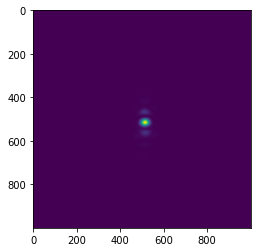

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import data
from skimage.color import rgb2gray

im1 = plt.imread('1234.jpg')
im1 = rgb2gray(im1)

plt.imshow(Full_propagation(im1, L=0.003, R=0.0015, f=0.5, z=0.5))
plt.show()

Mediante la OTF se simula la formación de la imágen directamente en el foco (Franhoufer)

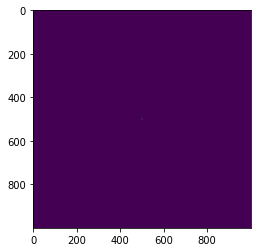

In [12]:
plt.imshow(Prop_OTF(im1, L=0.003))
plt.show()